In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.stats.api as sm
import statsmodels.stats.power as sp

plt.rc("figure", figsize=(16, 10))

In [2]:
def plot_normal(mu=0, variance=1, label=""):
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.plot(x, st.norm.pdf(x, mu, sigma), label=label)

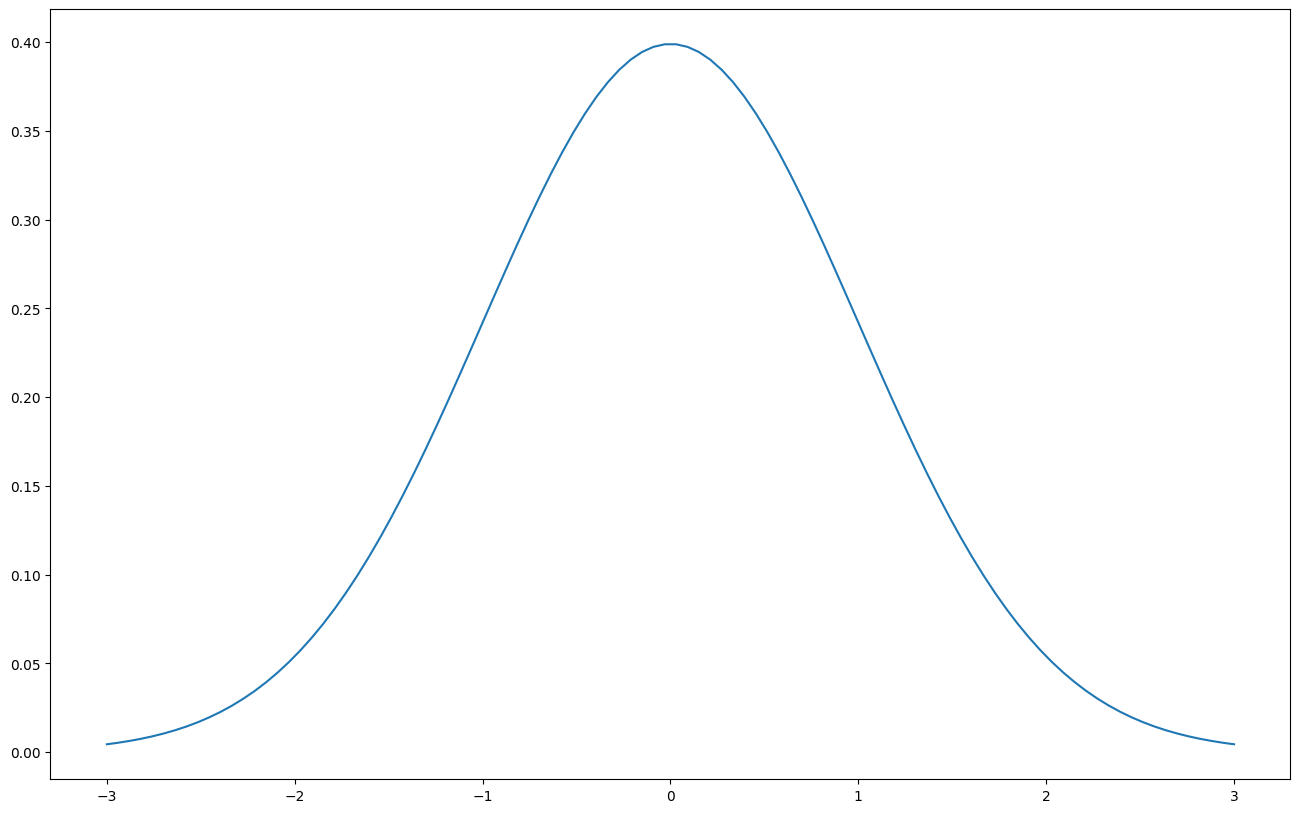

In [3]:
mu = 0
variance = 1
plot_normal(mu, variance)

In [4]:
class Money:
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return "${:.2f}".format(self.value)


class Exchange:
    def __init__(self, name, cost):
        self.name = name
        self.cost = cost

    def sample(self) -> int:
        return self.cost + np.random.normal()


class TimeOfDayEffectWrapper:
    def __init__(self, exchange: Exchange):
        self.exchange = exchange

    def sample(self, tod="afternoon"):
        bias = 2.5 if tod == "morning" else 0.0
        return self.exchange.sample()


asdaq = Exchange(name="ASDAQ", cost=12)
print(Money(asdaq.sample()))

asdaq = TimeOfDayEffectWrapper(asdaq)
print(Money(asdaq.sample("morning")))
print(Money(asdaq.sample("afternoon")))

byse = Exchange(name="BYSE", cost=10)
byse = TimeOfDayEffectWrapper(byse)
print(Money(byse.sample()))

$11.37
$12.52
$11.57
$12.45


In [5]:
print(Money(np.mean([byse.sample() for _ in range(100)])))
print(Money(np.mean([asdaq.sample() for _ in range(100)])))

$9.81
$11.99


In [6]:
def aggregate_measurements(n, exchange: Exchange):
    return np.mean([exchange.sample() for _ in range(n)])


print(np.std([aggregate_measurements(10, asdaq) for _ in range(1000)]))
print(np.std([aggregate_measurements(100, asdaq) for _ in range(1000)]))
print(np.std([aggregate_measurements(1000, asdaq) for _ in range(1000)]))

0.3216773191685056
0.09896203464547156
0.03151095966965939


In [7]:
sample_size = 10
sample_count = 1000

sample_population = np.array(
    [aggregate_measurements(sample_size, asdaq) for _ in range(sample_count)]
)
print("Mean: {:.4f}".format(sample_population.mean()))
print("Std Error: {:.4f}".format(st.sem(sample_population)))
print("Std Deviation: {:.4f}".format(sample_population.std()))

Mean: 12.0027
Std Error: 0.0100
Std Deviation: 0.3163


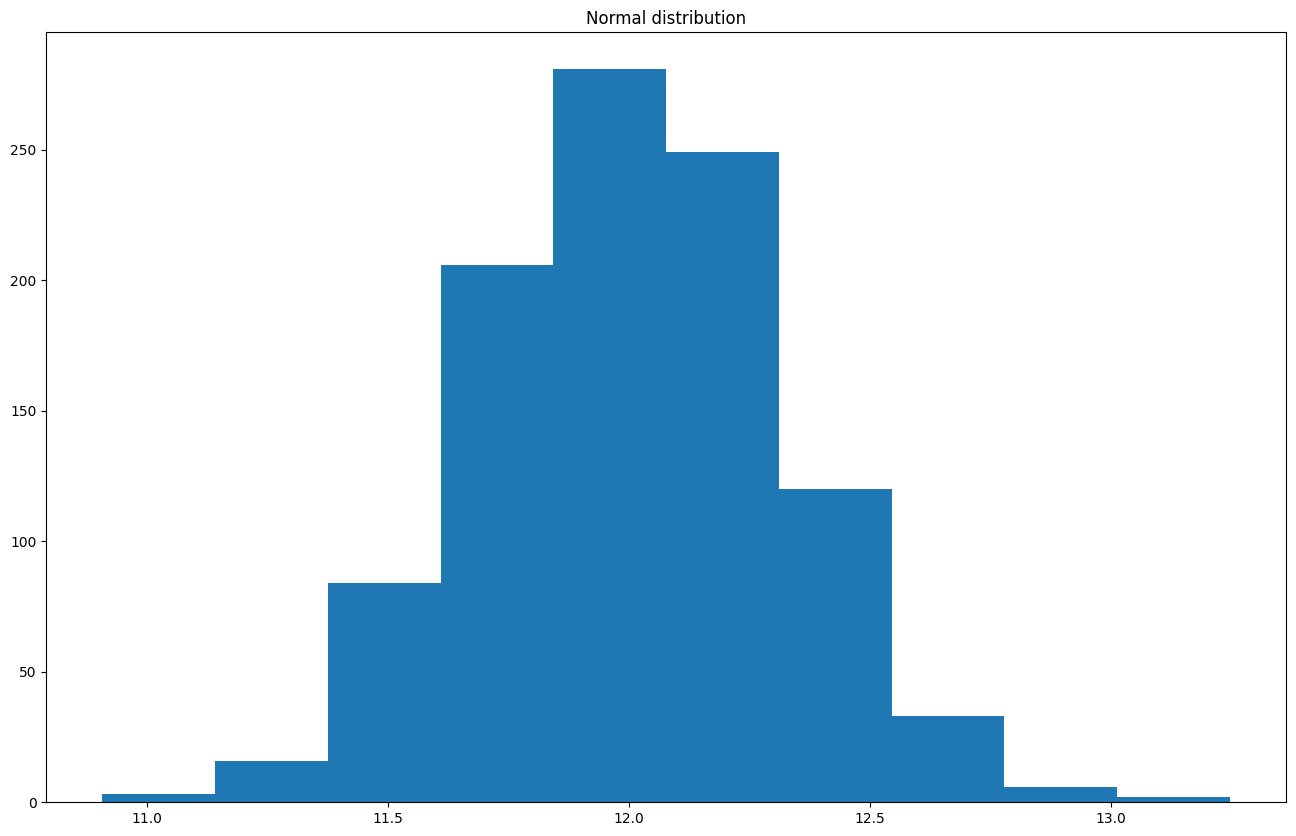

In [8]:
plt.hist(sample_population)
plt.title("Normal distribution");

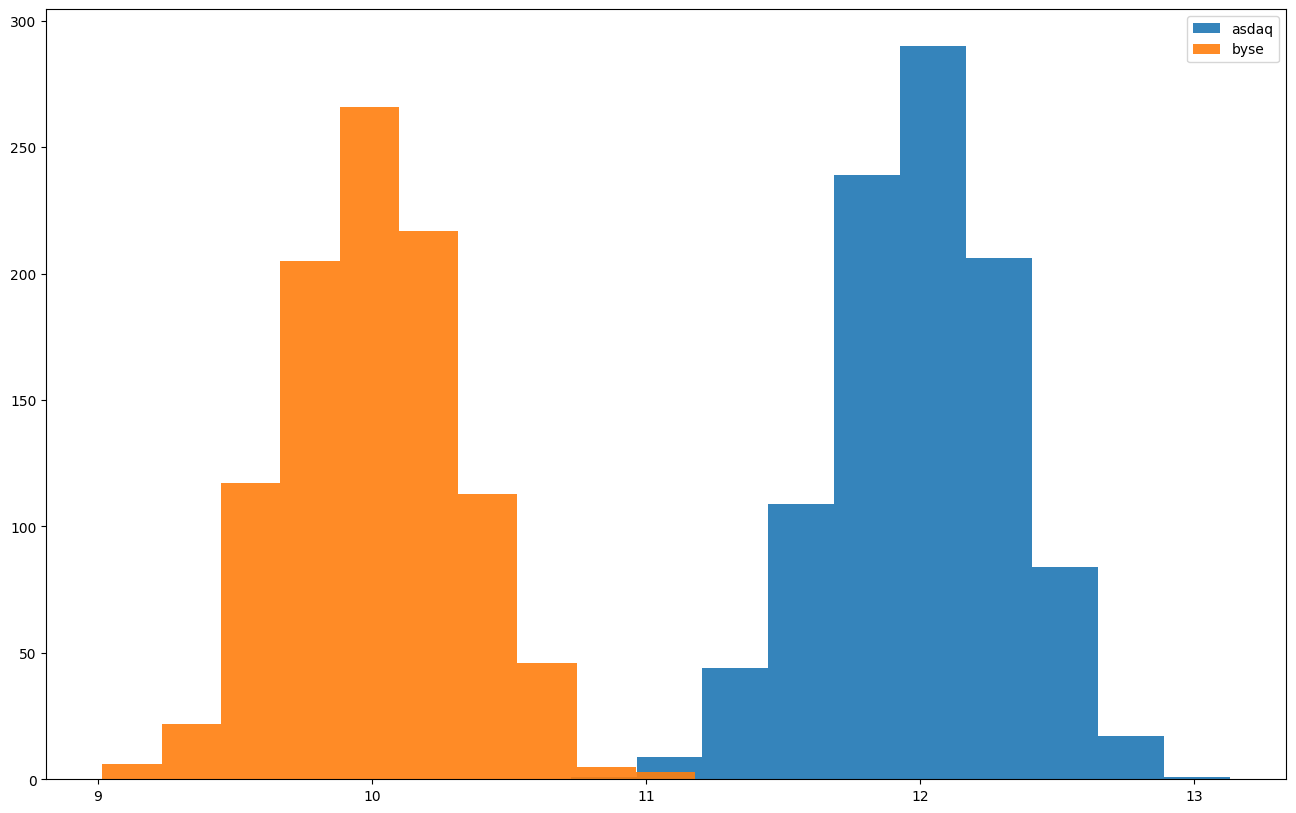

In [9]:
asdaq_sample = np.array(
    [aggregate_measurements(sample_size, asdaq) for _ in range(sample_count)]
)
byse_sample = np.array(
    [aggregate_measurements(sample_size, byse) for _ in range(sample_count)]
)
plt.hist(asdaq_sample, label="asdaq", alpha=0.9)
plt.hist(byse_sample, label="byse", alpha=0.9)
plt.legend();

The more average measurements we take, the smaller the standard deviation.

In [10]:
alpha = 0.05
beta = 0.2

diff = 1
power = 1 - beta
n1 = sp.normal_sample_size_one_tail(
    diff, power, alpha, std_null=1, std_alternative=None
)
n1 = int(np.ceil(n1))
print("at least {} individual measurements are needed".format(n1))

at least 7 individual measurements are needed


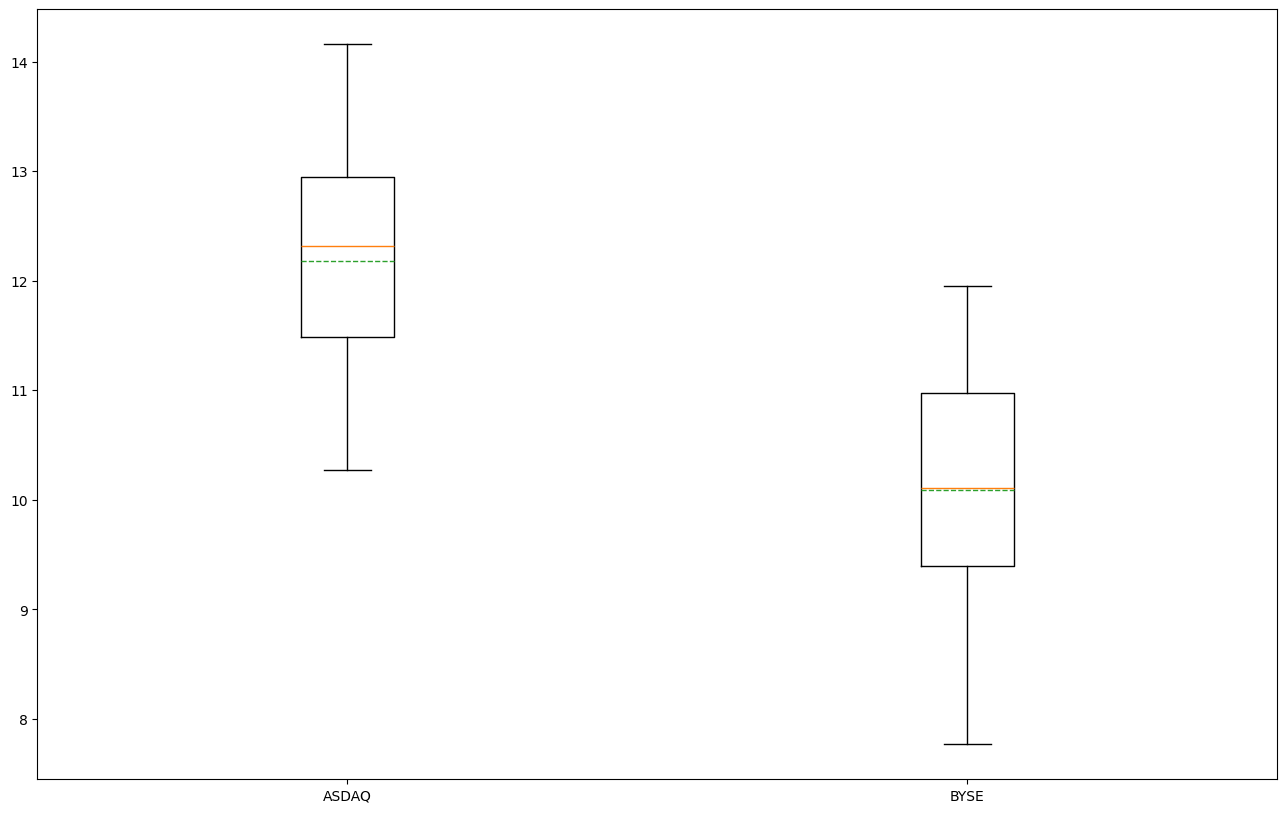

In [11]:
n = 30
asdaq_samples = []
byse_samples = []

# Randomly collecting samples for both ASDAQ and NYSE.
while len(asdaq_samples) < n or len(byse_samples) < n:
    if np.random.random() < 0.5:
        asdaq_samples.append(asdaq.sample())
    else:
        byse_samples.append(byse.sample())

plt.boxplot(
    [asdaq_samples, byse_samples],
    tick_labels=["ASDAQ", "BYSE"],
    showmeans=True,
    meanline=True,
);

In [12]:
sem = st.sem(asdaq_samples)
std = np.std(asdaq_samples)
mean = np.mean(asdaq_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(asdaq_samples))

sem=0.1789 | std=0.9632 | mean=12.1839
30


In [13]:
sem = st.sem(byse_samples)
std = np.std(byse_samples)
mean = np.mean(byse_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(byse_samples))

sem=0.1987 | std=1.0699 | mean=10.0852
30


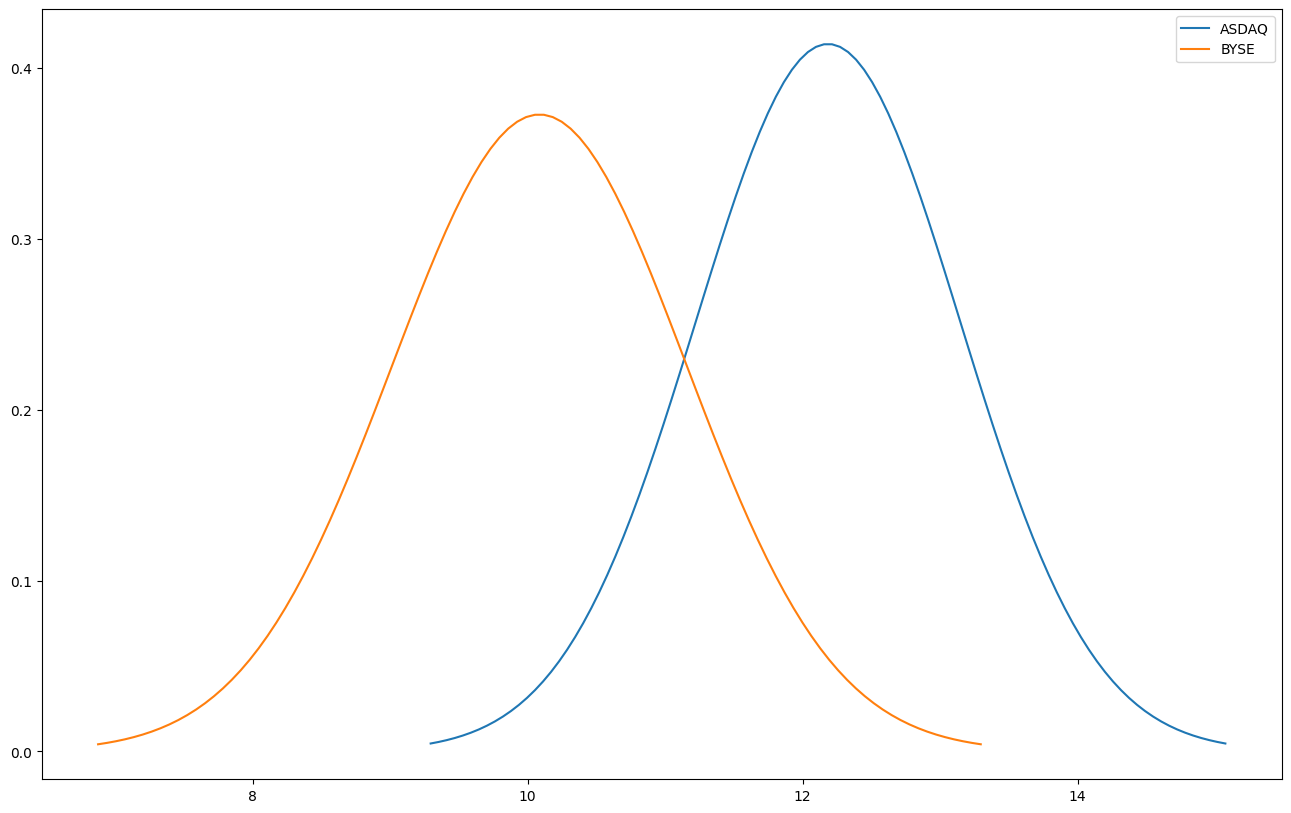

In [14]:
plot_normal(np.mean(asdaq_samples), np.var(asdaq_samples), label="ASDAQ")
plot_normal(np.mean(byse_samples), np.var(byse_samples), label="BYSE")
plt.legend();

In [15]:
# NOTE: The position of the X values are important.
# X1 - X2, for smaller alternative.
tstat, pvalue = sm.ztest(
    asdaq_samples,  # Control, A
    byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
tstat, pvalue, pvalue < 0.05, st.norm.sf(tstat)

(7.850943901681989, 2.0645882083658725e-15, True, 2.0645882083658725e-15)

In [16]:
# correct if the population S.D. is expected to be equal for the two groups.
def cohens_d(x1, x2):
    """
    Specify the division argument on the variance with ddof=1 into the std function,
    i.e. numpy.std(c0, ddof=1).
    numpy's standard deviation default behaviour is to divide by n,
    whereas with ddof=1 it will divide by n-1.
    """
    n1 = len(x1)
    n2 = len(x2)
    s1 = np.std(x1, ddof=1)
    s2 = np.std(x2, ddof=1)
    # We can also operate under the assumption that the standard deviation of s2 = s1

    # Difference in mean
    u = np.mean(x1) - np.mean(x2)
    # Pooled standard deviation.
    s = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return u / s


es = cohens_d(asdaq_samples, byse_samples)
es

2.027104998881535

In [17]:
import statistics

statistics.stdev(asdaq_samples), np.std(asdaq_samples, ddof=1)

(0.9796914614424987, 0.9796914614424987)

In [18]:
es, var_ = sm.effectsize_smd(
    # Treatment.
    np.mean(byse_samples),
    np.std(byse_samples, ddof=1),
    len(byse_samples),
    # Control.
    np.mean(asdaq_samples),
    np.std(asdaq_samples, ddof=1),
    len(asdaq_samples),
)
es = np.abs(es)
es, var_

(2.000778959935021, 0.10237052366380067)

In [19]:
# es = 1 / 1
alpha = 0.05
power = 0.8
sm.NormalIndPower().solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

3.0888720398399876

In [20]:
sm.zt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

3.0888720398399876

In [21]:
sm.tt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

3.9847615236149254

If both sample has the same size, the pooled variance is simple the average:

In [22]:
def sample_size(x1, x2, alpha=0.05, beta=0.2, kappa=1.0):
    # Sampling ratio, κ = n_1 / n_2
    # Type I error rate, α
    # Type II error rate, β
    # Mean of group 1, μ_1 and Mean of group 2, μ_2
    u1, u2 = np.mean(x1), np.mean(x2)
    # Sample standard deviation of group 1 and Sample standard deviation of group 2
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    # We can also operate under the assumption that the standard deviation is the same.
    # s2 = s1

    n1 = (s1**2 + s2**2 / kappa) * (
        (st.norm.ppf(1 - alpha) + st.norm.ppf(1 - beta)) / (u1 - u2)
    ) ** 2
    return n1


sample_size(asdaq_samples, byse_samples)

3.00916257418671

In [23]:
def analyze(x1, x2):
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    u1, u2 = np.mean(x1), np.mean(x2)
    n1, n2 = len(x1), len(x2)

    # If the variance are equal, we can use the pooled variance.
    # pooled_var = ((n_1 - 1) * s_1**2 + (n_2 - 1) * s_2**2) / (n_1 - 1 + n_2 - 1)
    u = u1 - u2
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    z = u / s
    p = st.norm.sf(z)
    return z, p


analyze(asdaq_samples, byse_samples)

(7.850943901681989, 2.0645882083658725e-15)

In [24]:
x1 = asdaq_samples
x2 = byse_samples
sm.ttest_ind(
    x1, x2, alternative="larger", usevar="unequal", weights=(None, None), value=0
)

(7.850943901681982, 5.833343885895734e-11, 57.372038438430415)

In [25]:
## Validating

# Number of individual samples to collect.
n = 3
test_asdaq_samples = np.random.choice(asdaq_samples, n)
test_byse_samples = np.random.choice(byse_samples, n)

In [26]:
tstat, pvalue = sm.ztest(
    test_asdaq_samples,  # Control, A
    test_byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
print("z-score:", np.round(tstat, 4))
print("p-value:", np.round(pvalue, 4))
print("reject h0:", pvalue < 0.05)

z-score: 0.8652
p-value: 0.1935
reject h0: False


In [27]:
tstat, pvalue, df = sm.ttest_ind(
    test_asdaq_samples,  # Control, A
    test_byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
print("z-score:", np.round(tstat, 4))
print("p-value:", np.round(pvalue, 4))
print("df:", df)
print("reject h0:", pvalue < 0.05)

z-score: 0.8652
p-value: 0.2195
df: 3.7253810647154575
reject h0: False


In [28]:
st.ttest_ind(test_asdaq_samples, test_byse_samples)

TtestResult(statistic=0.8651649798238944, pvalue=0.4357510496026244, df=4.0)

In [29]:
n = 3

test_asdaq_samples = np.random.choice(asdaq_samples, n)
# Assuming we use the same samples as ASDAQ, just different measurements.
test_byse_samples = np.random.choice(asdaq_samples, n)
tstat, pvalue = sm.ztest(
    test_asdaq_samples,  # Control, A
    test_byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
print("z-score:", np.round(tstat, 4))
print("p-value:", np.round(pvalue, 4))
print("reject h0:", pvalue < 0.05)

z-score: 1.2243
p-value: 0.1104
reject h0: False


In [30]:
st.ttest_ind(test_asdaq_samples, test_byse_samples)

TtestResult(statistic=1.22429307496321, pvalue=0.28801701679227576, df=4.0)